In [94]:
import pandas as pd
import geopandas as gpd
import cbsodata
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from os import listdir
from os.path import isfile, join

In [84]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Zoek op welke data beschikbaar is
metadata = pd.DataFrame(cbsodata.get_meta('83765NED', 'DataProperties'))

In [91]:
#TotaalCBSTabel = pd.DataFrame(cbsodata.get_data('60048NED'))

In [168]:
cbsTabelOrgineel = pd.DataFrame(cbsodata.get_data('60048NED', select = ["Perioden", "RegioS", "k_15Tot20Jaar_93", "k_20Tot25Jaar_94", "k_15Tot20Jaar_162", "k_20Tot25Jaar_163"]))
cbsTabelOrgineel = cbsTabelOrgineel.rename(columns = {"k_15Tot20Jaar_93": "Gevestigd_15_20", 
                                                      "k_20Tot25Jaar_94": "Gevestigd_20_25", 
                                                      "k_15Tot20Jaar_162": "Vertrokken_15_20", 
                                                      "k_20Tot25Jaar_163": "Vertrokken_20_25"})
cbsTabelOrgineel["Vertrokken"] = cbsTabelOrgineel.Vertrokken_15_20 + cbsTabelOrgineel.Vertrokken_20_25
cbsTabelOrgineel["Gevestigd"] = cbsTabelOrgineel.Gevestigd_15_20 + cbsTabelOrgineel.Gevestigd_20_25
cbsTabelOrgineel.head()

,Perioden,RegioS,Vertrokken_15_20,Gevestigd_15_20,Vertrokken_20_25,Gevestigd_20_25,Vertrokken,Gevestigd
0,1988,Nederland,58151.0,58151.0,132599.0,132599.0,190750.0,190750.0
1,1989,Nederland,57134.0,57134.0,137107.0,137107.0,194241.0,194241.0
2,1990,Nederland,53024.0,53024.0,131743.0,131743.0,184767.0,184767.0
3,1991,Nederland,50282.0,50282.0,129663.0,129663.0,179945.0,179945.0
4,1992,Nederland,47487.0,47487.0,129569.0,129569.0,177056.0,177056.0


In [169]:
dfStudenten = pd.read_csv("VerhuisdePersonen15-25.csv", sep = ";")
dfStudenten = dfStudenten.dropna()
dfStudenten = dfStudenten.rename(columns = {"Regio's": "Regio"})

In [186]:
data2010

,Perioden,RegioS,Vertrokken_15_20,Gevestigd_15_20,Vertrokken_20_25,Gevestigd_20_25,Vertrokken,Gevestigd
2657,2010,Amsterdam,1395.0,3860.0,5479.0,10217.0,6874.0,14077.0


In [187]:
uniekeGemeentes = cbsTabel.RegioS.unique()
dataGemeente = cbsTabel.loc[cbsTabel.RegioS == uniekeGemeentes[0]]
data2010 = dataGemeente.loc[dataGemeente.Perioden.astype(int) == 2010]
dataGemeente["Index2010"] = dataGemeente.Gevestigd.apply(lambda x: int(x)/data2010.Gevestigd * 100)
dataGemeente

,Perioden,RegioS,Vertrokken_15_20,Gevestigd_15_20,Vertrokken_20_25,Gevestigd_20_25,Vertrokken,Gevestigd,Index2010
2660,2013,Amsterdam,1365.0,3855.0,6290.0,11703.0,7655.0,15558.0,110.520708
2661,2014,Amsterdam,1469.0,3678.0,6668.0,11580.0,8137.0,15258.0,108.389572
2662,2015,Amsterdam,1301.0,3080.0,6785.0,12088.0,8086.0,15168.0,107.750231
2659,2012,Amsterdam,1344.0,3786.0,6373.0,11289.0,7717.0,15075.0,107.089579
2663,2016,Amsterdam,1252.0,2677.0,6630.0,11460.0,7882.0,14137.0,100.426227
2657,2010,Amsterdam,1395.0,3860.0,5479.0,10217.0,6874.0,14077.0,100.000000
2658,2011,Amsterdam,1368.0,3671.0,5717.0,10245.0,7085.0,13916.0,98.856290
2664,2017,Amsterdam,1216.0,2346.0,6592.0,10459.0,7808.0,12805.0,90.963984
2665,2018,Amsterdam,1238.0,2125.0,6449.0,9684.0,7687.0,11809.0,83.888613


In [196]:
cbsTabel = cbsTabelOrgineel.loc[cbsTabelOrgineel.RegioS.isin(dfStudenten.Regio), :]
cbsTabel = cbsTabel.loc[cbsTabel.Perioden.astype(int) >= 2010, :]
cbsTabel = cbsTabel.dropna()
cbsTabel.RegioS = cbsTabel.RegioS.str.replace(" \(gemeente\)", "")
cbsTabel.Gevestigd = cbsTabel.Gevestigd//1000
cbsTabel.Vertrokken = cbsTabel.Vertrokken//1000

    
cbsTabel = cbsTabel.sort_values(by = "Gevestigd", ascending = False)

In [197]:
gemeenteData = pd.merge(gemeentegrenzen, cbsTabel.head(40),
                           left_on = "statnaam", 
                           right_on = "RegioS",
                       how = "outer")


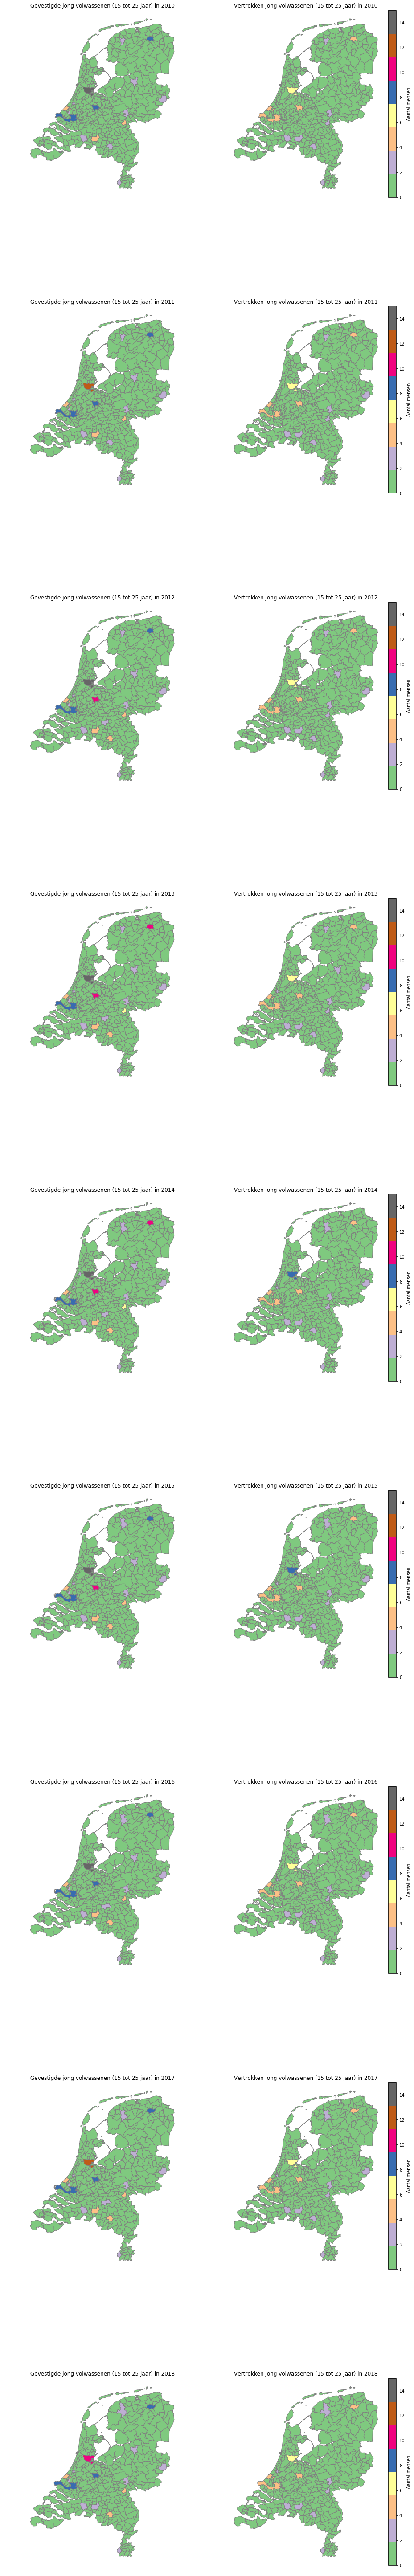

In [199]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap = cm.get_cmap('Accent') # wissel tussen Accent en YlOrBr

vmin = 0
vmax = max(cbsTabel.Gevestigd.max(), cbsTabel.Vertrokken.max())
onlyfiles = ["GemeenteGrenzen{}.geojson".format(jaar) for jaar in range(2010, 2019)]


fig, axes = mpl.pyplot.subplots(ncols=2, nrows = len(onlyfiles), figsize = [15, 12*len(onlyfiles)])
for ii in range(len(onlyfiles)):
    file = onlyfiles[ii]
    gemeentegrenzen = gpd.read_file("grenzen/" + file, driver = "GeoJSON")
    jaar = file[-12:-8]
    
    
    cbsJaarTabel = cbsTabel.loc[cbsTabel.Perioden.astype(int) == int(jaar), :].head(40)
    gemeenteData = pd.merge(gemeentegrenzen, cbsJaarTabel,
                           left_on = "statnaam", 
                           right_on = "RegioS",
                           how = "outer")
    
    # Maak een thematische kaart
    p1 = gemeenteData.plot(ax = axes[ii][0],
                          column='Gevestigd', 
                          figsize = (10,8),
                          edgecolor = "grey",
                          cmap = cmap,
                          vmin = vmin,
                          vmax = vmax)
    p1.axis('off')
    p1.set_title("Gevestigde jong volwassenen (15 tot 25 jaar) in {}".format(jaar))

    p2 = gemeenteData.plot(ax = axes[ii][1],
                          column='Vertrokken', 
                          figsize = (15,12),
                          edgecolor = "grey",
                          cmap = cmap,
                          vmin = vmin,
                          vmax = vmax)
    p2.axis('off')
    p2.set_title("Vertrokken jong volwassenen (15 tot 25 jaar) in {}".format(jaar))
    
    divider = make_axes_locatable(axes[ii][0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cax.axis('off')
    
    divider2 = make_axes_locatable(axes[ii][1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    
    sm = cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbr = plt.colorbar(sm, cax = cax2, ax = axes[ii][1])
    cbr.set_label("Aantal mensen")

fig.show()

In [177]:
fig.savefig("Verhuizing jongeren 2010-2018.pdf", quality = 95, format = "pdf")